In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mpl import cross_valid
from sklearn import metrics
from sklearn import model_selection


In [2]:
itch_dt = pd.read_csv('data/ericson_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                                "Condition":"condition",
                                "Question":"question_id",
                                "X1":"ss_x",
                                "T1":"ss_t",
                                "X2":"ll_x",
                                "T2":"ll_t",
                                "LaterOptionChosen": "choice"}).\
                drop(['R','G','D'],axis=1)


# Define features, label, and group variable
features = ['ss_x', 'ss_t', 'll_x', 'll_t',
            'abs_diff_x', 'abs_diff_t', 'rel_diff_x','rel_diff_t',
            'growth_x']
label = 'choice'
group = 'person_id'

# Omit the choice questions of which ss_x <= 5
# After omission, 9 persons that answers less than 10 questions (maximum is 23 questions)
# Removew these persons from the dataset
dataset = itch_dt[itch_dt['ss_x'] > 5]
count_indvd_choice = dataset.groupby('person_id').choice.count()
person_id_omit = list(count_indvd_choice[count_indvd_choice <= 10].index)
dataset = dataset[~dataset['person_id'].isin(person_id_omit)]

data_prepare = cross_valid.data_prepare(data=dataset,feature=features,label=label,group=group)
data_prepare.generate_features()
dataset = data_prepare._data

# Split the data into train sample and test sample
# Train sample containts 80% of the participants, test sample contains the rest 
X_train,X_test,y_train,y_test = data_prepare.split_sample(test_size=0.2)
groups = data_prepare.train_sample[group]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=X_train,y=y_train,groups=groups))

In [3]:
len(set(dataset['person_id']))

930

In [4]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
# The following dictionary directly shows the tuning results 
param_grid = {'n_estimators': [40],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.3],
              'reg_lambda': [.7],
              'subsample': [.55],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, 
                                           cv=cv, 
                                           scoring=["accuracy","neg_log_loss",'neg_mean_absolute_error','neg_mean_squared_error'], 
                                           refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=X_train,y=y_train,groups=groups)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 12330, 12331, 12332]),
                  array([   72,    73,    74, ..., 12248, 12249, 12250])),
                 (array([    0,     1,     2, ..., 12330, 12331, 12332]),
                  array([   21,    22,    23, ..., 12168, 12169, 12170])),
                 (array([    0,     1,     2, ..., 12330, 12331, 12332]),
                  array([  629,   630,   631, ..., 12297, 12298, 12299])),
                 (array([    0,     1,     2, ..., 12330, 12331, 12332]),
                  array([  176,   177,   178, ..., 12187, 12188, 12189])),
                 (array([    0,     1...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.3],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [40], 'reg_lambda': [0.7],
                         'subsample': [0.55]},
             refit='neg_log_loss',
             scoring=['accuracy', 'neg_log_loss', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'],
             verbose=3)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

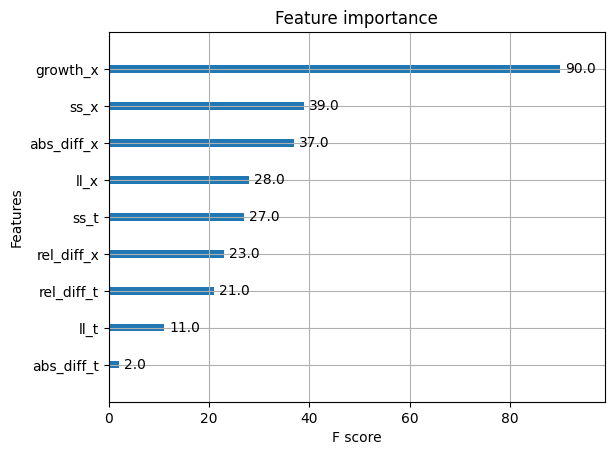

In [5]:
# Save the XGBoost model and check the feature importance
bst_model = grid_search.best_estimator_

with open('my_model_followup.pkl', 'wb') as f:
    pickle.dump(bst_model, f)


heuristic_kf_dict = {'dstyle': 'heuristic',
            'ustyle': '--',
            'params': None,
            'accuracy': grid_search.cv_results_['mean_test_accuracy'][0],
            'log_loss': -grid_search.cv_results_['mean_test_neg_log_loss'][0],
            'mse':-grid_search.cv_results_['mean_test_neg_mean_squared_error'][0],
            'mae':-grid_search.cv_results_['mean_test_neg_mean_absolute_error'][0]
            }

xgb.plot_importance(bst_model)

In [6]:
# Plot a decision tree
# To check structure of different trees, change num_trees 
#xgb.to_graphviz(bst_model, num_trees=1)

In [7]:
# Fit data by distounted utility model and trade-off model
style_list = cross_valid.estimation.gen_style_list()
train_sample = data_prepare.train_sample

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)
kf.fit()

100%|██████████| 220/220 [51:31<00:00, 14.05s/it]  


In [8]:
# Check if some of the fits fail to converge 
np.where(kf.success==False)

(array([], dtype=int64),)

In [9]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result = kf_result_df.drop('style',axis=1)
kf_result = pd.concat([kf_result,pd.DataFrame(heuristic_kf_dict,index=[99])]).sort_values('log_loss')
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
99,heuristic,--,None,0.270513,0.270513,0.557676,0.729487,NaN
21,trade,power,"[0.524, 1.231, 7.45, 0.608, 0.114, 0.112]",0.192958,0.385622,0.572563,0.722129,0.200266
13,hbmd,power,"[8.931, 0.129, 0.148]",0.195510,0.391986,0.579438,0.723987,0.210993
17,quasihb,power,"[0.997, 0.997, 0.011, 0.007]",0.196137,0.392524,0.580285,0.722592,0.224947
19,quasihb_fc,power,"[0.997, 0.997, 0.961, 0.011, 0.007]",0.196274,0.392667,0.580611,0.722592,0.224947
3,attention_uni,power,"[0.218, 0.017, 0.011]",0.196212,0.393323,0.580823,0.725026,0.214443
7,expo2,power,"[0.824, 0.905, 0.357, 0.012, 0.008]",0.196287,0.393447,0.580837,0.723149,0.219764
9,hb,power,"[0.002, 0.007, 0.004]",0.197862,0.396756,0.584151,0.718838,0.230490
15,hce,power,"[0.997, 2.207, 0.006, 0.006]",0.197913,0.396547,0.584309,0.720067,0.232134
5,expo,power,"[0.997, 0.007, 0.005]",0.197962,0.395719,0.584534,0.717927,0.229382


In [10]:
# Compare models: Out-of-sample performance
test_sample = data_prepare.test_sample
test_result = cross_valid.get_result_tab(kf_result_df,test_sample)

with open('my_model_followup.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

heuristic_test_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,X_test=X_test,y_test=y_test)

test_result = pd.concat([test_result,pd.DataFrame(heuristic_test_dict,index=[99])]).sort_values('accuracy',ascending=False)
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.183912,0.372364,0.549802,0.731238,0.232842
17,quasihb,power,0.192847,0.396727,0.571953,0.728352,0.221616
19,quasihb_fc,power,0.192847,0.396727,0.571953,0.728352,0.221616
13,hbmd,power,0.192796,0.387969,0.572272,0.726748,0.206543
11,hb2,power,0.199746,0.416136,0.588620,0.726106,0.242463
15,hce,power,0.196555,0.402264,0.580551,0.726106,0.242463
9,hb,power,0.195908,0.399463,0.579710,0.726106,0.242463
3,attention_uni,power,0.193756,0.387356,0.574105,0.724182,0.203335
21,trade,power,0.189050,0.379458,0.562208,0.720654,0.192110
5,expo,power,0.199147,0.393335,0.586756,0.707826,0.157473


In [11]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction value by XGBoost as the label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = itch_dt[itch_dt.index.isin(np.random.choice(itch_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_prepare = cross_valid.data_prepare(data=rda_sample)
rda_prepare.generate_features()
rda_sample = rda_prepare._data[features]
rda_sample[label] = heuristic_model.predict(rda_sample[features])

rda_result = cross_valid.get_result_tab(kf_result_df,rda_sample)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
13,hbmd,power,0.120041,0.327930,0.411733,0.941,0.234
3,attention_uni,power,0.110355,0.307411,0.385840,0.935,0.248
21,trade,power,0.112203,0.313654,0.392895,0.909,0.196
19,quasihb_fc,power,0.127589,0.335988,0.428471,0.905,0.338
17,quasihb,power,0.127589,0.335988,0.428471,0.905,0.338
5,expo,power,0.121370,0.324216,0.411763,0.899,0.242
9,hb,power,0.134200,0.339685,0.441643,0.891,0.366
15,hce,power,0.131047,0.341909,0.436958,0.891,0.366
11,hb2,power,0.152766,0.369628,0.485782,0.891,0.366
1,attention,power,0.160337,0.378738,0.497720,0.838,0.135


In [12]:
# Use the prediction value by magnitude-dependent hyperbolic (hbmd) with power utillity as the label
# Examine which model can explain the hbmd's prediction the best
target_kf_row = kf_result_df[(kf_result_df['dstyle']=='trade') & (kf_result_df['ustyle']=='power')]
target_style = target_kf_row['style'].values[0]
target_params = target_kf_row['params'].values[0]

choice_prob = cross_valid.test_model(style=target_style,params=target_params,test_sample=rda_sample,output='predict_proba')
rda_sample[label] = (choice_prob >.5)

rda_result_2 = cross_valid.get_result_tab(kf_result_df,rda_sample).iloc[1:,:]
heuristic_rda_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,test_sample=rda_sample)
rda_result_2 = pd.concat([rda_result_2,pd.DataFrame(heuristic_rda_dict,index=[99])]).sort_values('accuracy',ascending=False)
rda_result_2

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
13,hbmd,power,0.119458,0.327347,0.410545,0.942,0.234
3,attention_uni,power,0.112254,0.309309,0.389609,0.924,0.248
99,heurstic,--,0.111276,0.308639,0.388806,0.909,0.277
1,attention,power,0.157249,0.375650,0.491466,0.905,0.135
5,expo,power,0.129902,0.332749,0.429847,0.886,0.242
19,quasihb_fc,power,0.148456,0.356855,0.473410,0.850,0.338
17,quasihb,power,0.148456,0.356855,0.473410,0.850,0.338
9,hb,power,0.159738,0.365224,0.498280,0.822,0.366
15,hce,power,0.147526,0.358389,0.472122,0.822,0.366
11,hb2,power,0.177643,0.394505,0.539656,0.822,0.366


In [13]:
# Save the results
kf_result.to_csv("itch_followup_kf.csv",index=False)
test_result.to_csv("itch_followup_test.csv",index=False)
rda_result.to_csv("itch_followup_rda.csv",index=False)